In [191]:
import cv2
import threading
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path
from tqdm import tqdm
from math import sqrt
from collections import namedtuple
from tqdm.auto import tqdm

# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}

matplotlib.rcParams.update(params)

In [36]:
THREADED_CAPTURE = False
TRACK_MIN_AREA = 100
TRACK_THRESHOLD = 60
LED_ROI_SIZE = 20 // 2 # half size
LED_THRESHOLD = 60

if THREADED_CAPTURE:
    VideoCapture = VideoCaptureThreading
else:
    VideoCapture = cv2.VideoCapture

In [4]:
Point = namedtuple('Point', ['x', 'y'])
kernel3 = np.ones((3,3), np.uint8)
kernel11 = np.ones((11,11), np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 12

In [5]:
class MaskGenerator:
    def __init__(self, path):
        self.path = Path(path)
        self.capture = VideoCapture(str(path))
        if THREADED_CAPTURE:
            self.capture.start()

        self.poly = []
        cv2.namedWindow("MaskMaker")
        cv2.setMouseCallback("MaskMaker", self.proc_event)
        
        self.mask = None
        self.mask_path = None
        
        self.loop()
    
    def loop(self):
        try:
            while True:
                rt, frame = self.capture.read()
                if not rt:
                    raise IOError("Could not load frame.")
                cv2.imshow('MaskMaker', self.annotate(frame))
                key = cv2.waitKey(30)
                if key > 0:
                    self.finish(frame)
                    break
        except KeyboardInterrupt:
            pass
        finally:
            cv2.destroyAllWindows()
    
    def proc_event(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.poly.append((x, y))
        elif event == cv2.EVENT_RBUTTONUP:
            self.poly.pop()
    
    def annotate(self, frame, alpha=.4, draw_points=True):
        overlay = frame.copy()
        if len(self.poly) > 1:
            pts = np.array(self.poly, dtype=np.int32)
            hull = cv2.convexHull(pts)
            cv2.fillConvexPoly(overlay, hull, (255, 255, 255, 0.5))
            cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)
        
        if draw_points:
            for p in self.poly:
                cv2.circle(frame, p, 3, (255, 0, 0, 255), cv2.FILLED)
        
        return frame
    
    def finish(self, frame):
        mask = np.zeros_like(frame)
        self.mask = self.annotate(mask, alpha=1, draw_points=False)
        mask_path = self.path.with_suffix('.mask.png')
        cv2.imwrite(str(mask_path), mask)
        self.mask_path = mask_path

# plt.imshow(MaskGenerator('smol.mp4').mask)

In [6]:
def centroid(cnt):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx, cy

In [78]:
class LED_Finder:
    def __init__(self, path, n_frames=50, threshold=40, verify=True):
        self.base_path = Path(path)
        self.capture = VideoCapture(str(path))
        if THREADED_CAPTURE:
            self.capture.start()
        
        self.frame_count = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        self.n_frames = min(self.frame_count, n_frames)

        self.std = None
        self.msk = None
        self.frame = None
        self.com = None
        self.hover = None
        self.find(threshold, verify)
        
    def find(self, threshold, verify):
        zstack = np.zeros((self.n_frames, self.height, self.width, 3), dtype='uint8')
        for n in tqdm(range(zstack.shape[0])):
            rt, f = self.capture.read()
            frame = cv2.cvtColor(f, cv2.COLOR_BGR2HSV_FULL)
            if not rt:
                raise IOError
                
            if not n:
                self.frame = frame

            zstack[n, ] = frame
        self.std = np.std(zstack, axis=0)
        msk = (self.std[:, :, 1] > threshold).astype('uint8')
        self.msk = cv2.morphologyEx(msk, cv2.MORPH_OPEN, kernel3)
        self.com = centroid(self.msk)
        
        if verify:
            try:
                cv2.namedWindow('LED Finder')
                cv2.setMouseCallback('LED Finder', self.process_event)
                n_frame = 0
                while True:
                    frame = zstack[n_frame, :].copy()
                    n_frame += 1
                    if n_frame >= zstack.shape[0]:
                        n_frame = 0
                    
                    # target circle
                    if self.com is not None:
                        cv2.circle(frame, self.com, 10, (255, 255, 0), 2)
                    
                    # hover circle
                    if self.hover is not None:
                        cv2.circle(frame, self.hover, 10, (190, 0, 190))

                    cv2.imshow('LED Finder', frame[:,:,2])
                    cv2.imshow('STD', self.msk*255)
                    key = cv2.waitKey(30)
                    if key > 1:  #== ord('q'):
                        break
            except KeyboardInterrupt:
                pass
            finally:
                cv2.destroyAllWindows()

    def process_event(self, event, x, y, flag, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            print(f'Updated LED position: {x}, {y}')
            self.com = (x, y)
        else:
            self.hover = (x, y)

# l = LED_Finder('C:/Users/reichler/Downloads/2019-04-29_12-00-10_eye01.scaled.mp4')
# plt.imshow(l.std[:,:,1])
# plt.colorbar()

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [9]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    cut = cutoff / nyq
    b, a = signal.butter(order, cut, btype='lowpass')
    return b, a

In [10]:
def euclidean_distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [163]:
def colorbar(mappable, size='5%', pad=0.05):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    return fig.colorbar(mappable, cax=cax)

In [86]:
class TrackResult:
    def __init__(self, n, tracked=True):
        self.n = n
        self.ts = None
        self.tracked = tracked
        self.detected = False
        self.largest_cnt = None
        self.largest_area = 0
        self.cx = None
        self.cy = None
        self.contours = []
        self.led_brightness = -1

In [12]:
def load_mask(path):
    """Load png of mask from disk, return as grayscale array"""
    mask_img = cv2.imread(path)
    print(mask_img)
    return cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)

In [147]:
class Tracker:
    def __init__(self, path, led_pos=None, start_offset=0, limit_frames=None, display=False, write_annotated=False, user_verify=True, threshold=TRACK_THRESHOLD, min_area=TRACK_MIN_AREA):
        self.base_path = Path(path)
        if not self.base_path.exists():
            raise FileNotFoundError('Can not find target {}'.format(self.base_path))
        self.start_offset = 0
        self.limit_frames = limit_frames
        self.min_area = min_area
        self.threshold = threshold
        self.display = display
        
        # Gather information on video
        self.led_pos = Point(*(led_pos if led_pos is not None else self.find_led_pos(verify=user_verify)))
        self.mask = self.get_mask()
        
        # Open capture
        self.capture = VideoCapture(str(self.base_path))
        if THREADED_CAPTURE:
            self.capture.start()

        self.frame_count = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.fps = self.capture.get(cv2.CAP_PROP_FPS)
        
        # Write annotated frames to disk?
        self.writer = None
        if write_annotated:
            raise NotImplementedError
#         self.writer = writer
#         if writer is None:
#             fourcc = cv2.VideoWriter_fourcc(*'XVID')
#             writer = cv2.VideoWriter(str(outpath), fourcc, fps, (width, height)) if writer else None
        
        self.led_lo = None
        self.led_hi = None
    
        # Frame buffers
        self.example_ON = None
        self.example_OFF = None
        self.ann = None
        
        # Annotation
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Dictionary containing tracking results
        # Frame number is used as key
        self.results = {n: TrackResult(n, tracked=False) for n in range(self.frame_count)}
        
        # Run!
        try:
            self.run()
        except BaseException as e:
            raise e
        finally:
            self.capture.release()
            cv2.destroyAllWindows()
            if self.writer is not None:
                writer.release()
        self.store_results()
        
    def find_led_pos(self, verify):
        com = LED_Finder(self.base_path, verify=verify).com
        print(f'Found LED at x={com[1]}, y={com[0]}')
        return com
    
    def get_mask(self):
        mask_path = self.base_path.with_suffix('.mask.png')
        if not mask_path.exists():
            print(f'No mask image found! Generating {mask_path}')
        
            MaskGenerator(self.base_path)
            print('Generated mask!')

        print(f'Loading mask from image {mask_path}')
        mask_img = cv2.imread(str(mask_path))
        return cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
    
    def run(self):
        kernel3 = np.ones((3, 3))
        end = self.frame_count
        if self.limit_frames is not None:
            end = min(self.start_offset + self.limit_frames, self.frame_count)

        for n in tqdm(range(self.start_offset, end)):
            current_frame_pos = self.capture.get(cv2.CAP_PROP_POS_FRAMES)
            current_msec_pos = self.capture.get(cv2.CAP_PROP_POS_MSEC)
            rt, frame = self.capture.read()
            if not rt:
                break

            ## Actual tracking stuff
            result = self.results[n]
            result.ts = current_msec_pos

            # prepare frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            masked = cv2.bitwise_and(gray, gray, mask=self.mask)
            rt, thr = cv2.threshold(gray, self.threshold, 255, cv2.THRESH_BINARY_INV)
            thr = cv2.bitwise_and(thr, thr, mask=self.mask)
            cleaned = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel3)

            # find contours
            try:
                _, contours, hierarchy = cv2.findContours(cleaned,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            except ValueError:
                contours, hierarchy = cv2.findContours(cleaned,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            result.contours = contours

            # Among contours above the minimimum area, find the largest one
            largest_area = 0
            for cnt in contours:
                area = int(cv2.contourArea(cnt))
                if area > self.min_area:
                    if area > largest_area:
                        result.largest_area = area
                        result.largest_cnt = cnt

            if result.largest_cnt is not None:
                result.detected = True
                result.cx, result.cy = centroid(result.largest_cnt)
            result.tracked = True

            # LED value
            led_brightness = np.median(gray[self.led_pos.y - LED_ROI_SIZE:self.led_pos.y + LED_ROI_SIZE, self.led_pos.x - LED_ROI_SIZE:self.led_pos.x + LED_ROI_SIZE])
            result.led_brightness = led_brightness
            
            # after Nth frame calculate the two peaks in the brightness histogram
            if n == 1000:
                print('Calculating the LED level distributon')
                led = [self.results[n].led_brightness for n in range(100)]
                led = [brightness for brightness in led if brightness > 0]
                self.led_lo = np.percentile(led, 10)
                self.led_hi = np.percentile(led, 90)

            # If the led extrema have been calculated, copy an example frame for each state
            if self.led_lo is not None and self.example_OFF is None:
                if abs(led_brightness - self.led_lo) < 5:
                    self.example_OFF = frame.copy()
                    print('Took LO example')
            if self.led_hi is not None and self.example_ON is None:
                if abs(led_brightness - self.led_hi) < 5:
                    self.example_ON = frame.copy()
                    print('Took HI example')
#             results[current_frame_pos] = result

            # Handle display or writing of annotated frames
            if self.display or self.writer:
                ann = frame  # optionally make a copy

                # frame number
                font_size = 1
                cv2.putText(ann, f'Frame: {n}', (25, 25), self.font, font_size, (255, 255, 255), 1, cv2.LINE_AA)

                # LED ROI
                cv2.rectangle(ann, (self.led_pos.x-LED_ROI_SIZE, self.led_pos.y-LED_ROI_SIZE),(self.led_pos.x + LED_ROI_SIZE, self.led_pos.y + LED_ROI_SIZE),(0,255,0), 2)
                
                cv2.putText(ann, f'LED: {led_brightness}', (self.led_pos.x + LED_ROI_SIZE + 5, self.led_pos.y), self.font, .5, (0, 0, 0), 2, cv2.LINE_AA)
                cv2.putText(ann, f'LED: {led_brightness}', (self.led_pos.x + LED_ROI_SIZE + 5, self.led_pos.y), self.font, .5, (255, 255, 255), 1, cv2.LINE_AA)

                # Contours
                if result.largest_cnt is not None:
                    ann = cv2.drawContours(frame, result.contours, -1, (150, 0, 0), 2)
                    ann = cv2.drawContours(ann, [result.largest_cnt], 0, (0, 0, 255), 3)
                    cv2.drawMarker(ann, (result.cx, result.cy), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=2, line_type=cv2.LINE_AA)
                    font_size = 0.5

                    cv2.putText(ann, f'{result.cx}:{result.cy}', (result.cx + 15, result.cy - 10), font, font_size, (0, 0, 0), 2, cv2.LINE_AA)
                    cv2.putText(ann, f'{result.cx}:{result.cy}', (result.cx + 15, result.cy - 10), font, font_size, (255, 255, 255), 1, cv2.LINE_AA)

                    cv2.putText(ann, f'{result.largest_area}', (result.cx + 15, result.cy + 4), font, font_size, (0, 0, 0), 2, cv2.LINE_AA)
                    cv2.putText(ann, f'{result.largest_area}', (result.cx + 15, result.cy + 4), font, font_size, (255, 255, 255), 1, cv2.LINE_AA)

                if self.writer is not None:
                    self.writer.write(ann)

                if self.display:
                    cv2.imshow('frame', frame)
                    cv2.imshow('masked', masked)
                    cv2.imshow('thr', cleaned)
                    if cv2.waitKey(30) > 0:
                        break

    def store_results(self):
        # store to csv file
        csv_path = self.base_path.with_suffix('.tracked.csv')
        with open(csv_path, 'w') as csv_file:
            csv_file.write('frame, was_tracked, led_brightness, x, y\n')
            keys = sorted(self.results.keys())
            for k in keys:
                r = self.results[k]
                line = f'{r.n}, {r.tracked}, {r.led_brightness}, {r.cx}, {r.cy}\n'
                csv_file.write(line)

    def generate_plots(self):
        raise NotImplementedError
        
# t = Tracker('smol.mp4', display=False)

In [148]:
tracker = Tracker('C:/Users/reichler/Downloads/2019-04-29_12-00-10_eye01.scaled.mp4', display=False, user_verify=False)

Found LED at x=334, y=41
Loading mask from image C:\Users\reichler\Downloads\2019-04-29_12-00-10_eye01.scaled.mask.png


Calculating the LED level distributon
Took HI example
Took LO example


### Position values

In [95]:
def pos_from_results(results):
    # POSITION DATA
    colormap = cm.jet
    xs = np.array([result.cx for result in results.values()], dtype=np.float)
    ys = np.array([result.cx for result in results.values()], dtype=np.float)
#     zs = colormap(np.linspace(0, 1, len(results)))

    # Estimate arena bounds from position extrema
    maze_start = Point(np.nanmin(xs), np.nanmin(ys))
    maze_end = Point(np.nanmax(xs), np.nanmax(ys))

    # Estimate arena length
    len_track = euclidean_distance(maze_start, maze_end)

    positions = np.zeros_like(xs)
    for n in range(len(xs)):
        if None not in [xs[n], ys[n]]:
            positions[n] = euclidean_distance((maze_start.x, maze_start.y), (xs[n], ys[n])) / len_track * 60
        else:
            positions[n] = np.nan
    return positions, xs, ys

In [98]:
def clean_positions(positions, fps=30.):
    # drop empty positions
    t = np.linspace(0, len(positions) / fps, len(positions))
    t = t[~np.isnan(positions)]
    positions = positions[~np.isnan(positions)]

    # Filter position data
    b, a = butter_lowpass(.2, fs=fps, order=5)
    pos_filtered = signal.filtfilt(b, a, positions)
    return t, positions, pos_filtered

In [105]:
p, xs, ys = pos_from_results(tracked.results)
t, p, pos_filtered = clean_positions(p)

Text(0.5, 1.0, 'Linear Track')

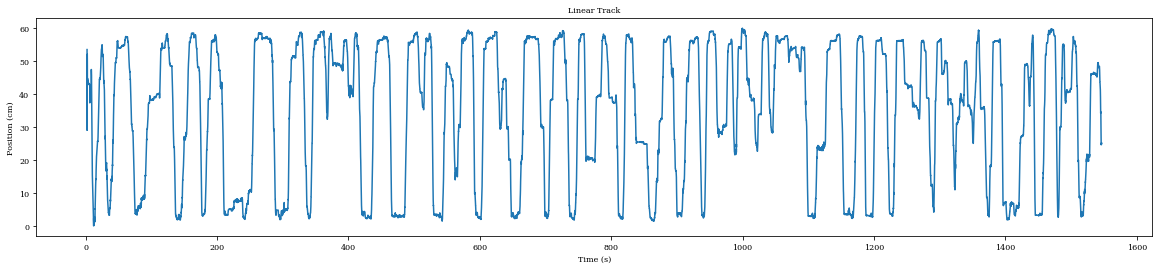

In [106]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(t, p)
plt.ylabel('Position (cm)')
plt.xlabel('Time (s)')
ax.set_title('Linear Track')

# plotpath = outpath.with_suffix('.positionplot.png')
# fig.savefig(outpath.with_suffix('.positionplot.png'))

### Speed

In [112]:
def speed_from_pos(positions, fps):
    return np.abs(np.diff(positions)) * fps

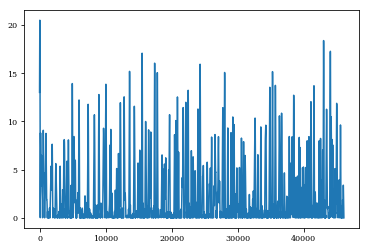

In [120]:
speed = speed_from_pos(pos_filtered, fps=30)
plt.plot(speed)

In [34]:
# fig, ax = plt.subplots(2, figsize=(20, 8), sharex=True)

# # Raw position values
# ax[0].plot(t, position)
# ax[0].set_ylabel('Position (cm)')
# ax[0].set_xlabel('Time (s)')

# plotpath = outpath.with_suffix('.positionplot.png')
# ax[0].set_title('Linear Track: ' + str(path.name))

# # ax[0].plot(t, pos_filtered)
# ax[0].set_xlabel('Time (s)')
# ax[0].set_ylabel('Position (cm)')

# # Speed
# ax[1].plot(t[1:], speed)
# ax[1].set_xlabel('Time (s)')
# ax[1].set_ylabel('Speed (cm/s)')

# plt.show()


In [35]:
# # Raw vs. filtered speed
# fig, ax = plt.subplots(2, figsize=(20, 8), sharex=True, sharey=True)
# ax[0].plot(speed_raw[100:])
# ax[1].plot(speed[100:])

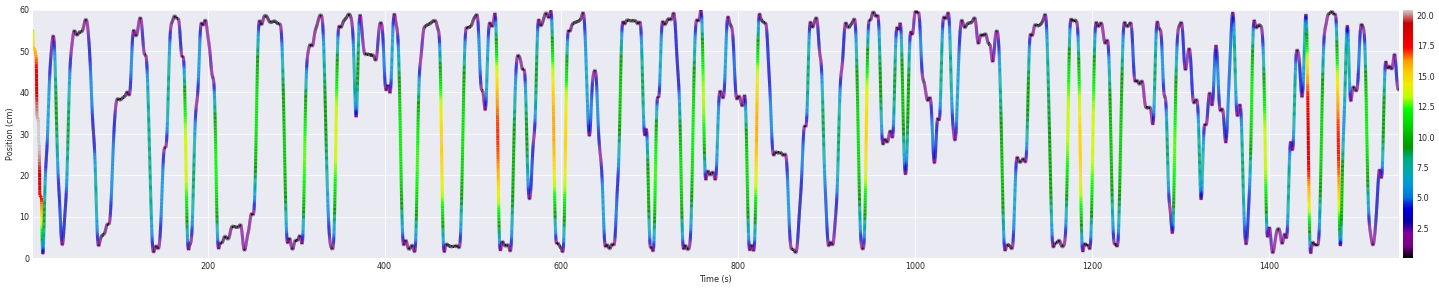

In [168]:
# Plot combined position and speed
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(figsize=(20, 4))

    plt.ylabel('Position (cm)')
    plt.xlabel('Time (s)')

    points = np.array([t[1:], pos_filtered[1:]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm=plt.Normalize(speed.min(), speed.max()) # 
    lc = LineCollection(segments, cmap=plt.get_cmap('nipy_spectral'), norm=norm)

    lc.set_array(speed)
    lc.set_linewidth(3)
    line = ax.add_collection(lc)
    colorbar(line, size=0.15)
#     cbar = fig.colorbar(line, ax=ax, pad=.02)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel('Speed (cm/s)', rotation=270)

    ax.set_xlim((t.min(), t.max()))
    ax.set_ylim((p.min(), p.max()))
    plt.tight_layout()


### LED values

In [70]:
led_threshold = LED_THRESHOLD
led_values = np.array([res.led_brightness for res in results.values()])
led_thresholded = (led_values > led_threshold).astype(np.float)
led_onsets = np.where(np.diff(led_thresholded) > 0)[0]
led_deltas = np.diff(led_onsets)

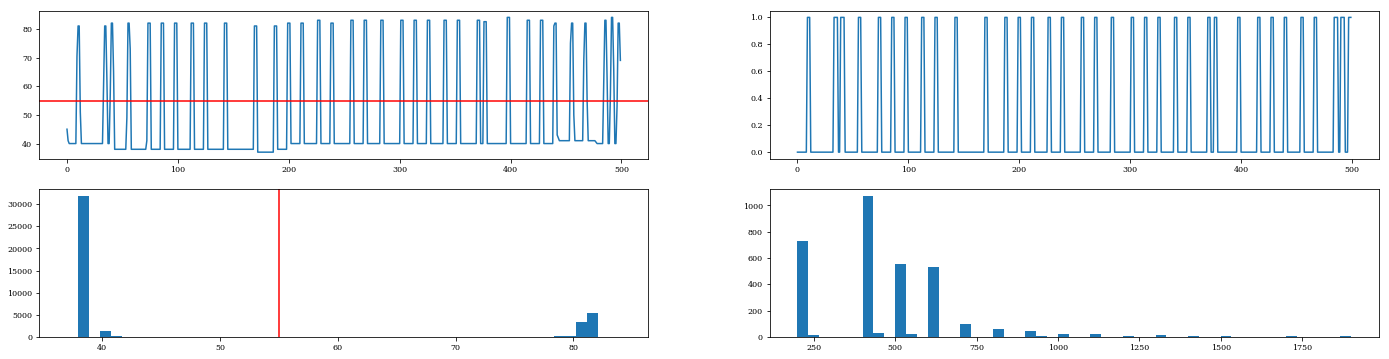

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(24, 6))
# raw traces
ax[0, 0].plot(led_values[:500])
ax[0, 0].axhline(led_threshold, color='red')

# raw value histogram
ax[1, 0].hist(led_values, bins=50)
ax[1, 0].axvline(led_threshold, color='red')

# onsets
ax[0, 1].plot(led_thresholded[:500])

# interval histogram
ax[1, 1].hist(led_deltas / fps * 1000, bins=led_deltas.max() - led_deltas.min());

# There are only 15 discrete time deltas, representing bit patterns.

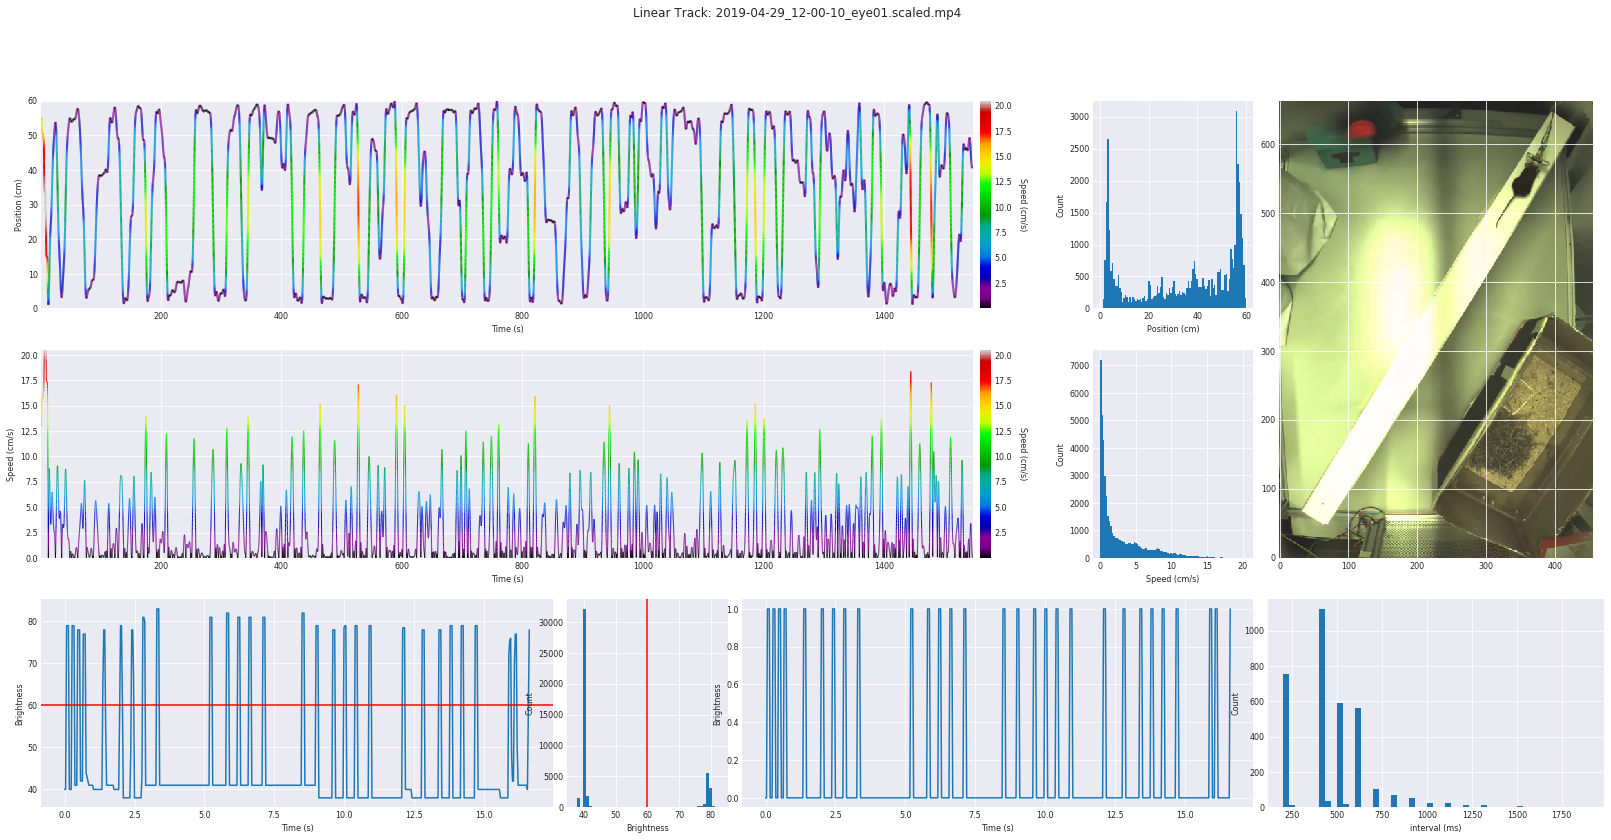

In [190]:
def figure_from_tracker(tracker):
    positions, xs, ys = pos_from_results(tracker.results)
    t, positions, pos_filtered = clean_positions(positions)
    speed = speed_from_pos(pos_filtered, 30.)
    
    led_threshold = LED_THRESHOLD
    led_ts = np.array([res.ts / 1000 for res in tracker.results.values()])
    led_values = np.array([res.led_brightness for res in tracker.results.values()])
    led_thresholded = (led_values > led_threshold).astype(np.float)
    led_onsets = np.where(np.diff(led_thresholded) > 0)[0]
    led_deltas = np.diff(led_onsets)
    
    with plt.style.context('seaborn-darkgrid'):

        color_map = 'nipy_spectral'  # 'nipy_spectral'

        fig = plt.figure(figsize=(28, 13))
        fig.suptitle('Linear Track: ' + str(tracker.base_path.name), fontsize=12)

        grid = plt.GridSpec(3, 18, wspace=0.2, hspace=0.2)

        # Position/speed plot
        ax_pos = plt.subplot(grid[0, 0:11])

        plt.xlabel('Time (s)')
        plt.ylabel('Position (cm)')

        points = np.array([t[1:], pos_filtered[1:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm=plt.Normalize(speed.min(), speed.max()) # 
        lc = LineCollection(segments, cmap=plt.get_cmap(color_map), norm=norm)

        lc.set_array(speed)
        lc.set_linewidth(2)
        line = ax_pos.add_collection(lc)

#         cbar = fig.colorbar(line, ax=ax_pos, pad=.02)
        cbar = colorbar(line, size=0.15, pad=0.1)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Speed (cm/s)', rotation=270)

        ax_pos.set_xlim((t.min(), t.max()))
        ax_pos.set_ylim((positions.min(), positions.max()))

        # Position histogram
        ax_pos_hist = plt.subplot(grid[0, 12:14])
        ax_pos_hist.hist(positions, bins=100)

        ax_pos_hist.set_xlabel('Position (cm)')
        ax_pos_hist.set_ylabel('Count')

        # Speed
        points = np.array([t[1:], speed]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm=plt.Normalize(speed.min(), speed.max()) # 
        lc = LineCollection(segments, cmap=plt.get_cmap(color_map), norm=norm)
        lc.set_array(speed)
        lc.set_linewidth(1)

        ax_v = plt.subplot(grid[1, 0:11], sharex=ax_pos)
        line = ax_v.add_collection(lc)

#         cbar = fig.colorbar(line, ax=ax_v, pad=.02)
        cbar = colorbar(line, size=0.15, pad=0.1)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Speed (cm/s)', rotation=270)

        ax_v.set_xlim((t.min(), t.max()))
        ax_v.set_ylim((speed.min(), speed.max()))

        ax_v.set_xlabel('Time (s)')
        ax_v.set_ylabel('Speed (cm/s)')


        # Speed histogram
        ax_v_hist = plt.subplot(grid[1, 12:14])
    #     ax_v_hist.hist(speed, bins=100, cumulative=True, density=True, histtype='step') # , log=True
        ax_v_hist.hist(speed, bins=100)

        ax_v_hist.set_xlabel('Speed (cm/s)')
        ax_v_hist.set_ylabel('Count')

        # LED trace
        ax_led = plt.subplot(grid[2, 0:6])
        ax_led.plot(led_ts[:500], np.array(led_values[:500]))
        ax_led.axhline(led_threshold, color='red')
        ax_led.set_ylabel('Brightness')
        ax_led.set_xlabel('Time (s)')

        ax_led_hist = plt.subplot(grid[2, 6:8])
        ax_led_hist.hist(led_values, bins=50)
        ax_led_hist.axvline(led_threshold, color='red')
        ax_led_hist.set_ylabel('Count')
        ax_led_hist.set_xlabel('Brightness') 

        ax_led_thr = plt.subplot(grid[2, 8:14])
        ax_led_thr.plot(led_ts[:500], np.array(led_thresholded[:500]))
        ax_led_thr.set_ylabel('Brightness')
        ax_led_thr.set_xlabel('Time (s)')

        ax_led_ipi_hist = plt.subplot(grid[2, 14:])
        ax_led_ipi_hist.hist(led_deltas / tracker.fps * 1000, bins=led_deltas.max() - led_deltas.min());
        ax_led_ipi_hist.set_ylabel('Count')
        ax_led_ipi_hist.set_xlabel('interval (ms)') 

        # Image
        ax_led_img = plt.subplot(grid[0:2, 14:])
        ax_led_img.imshow(cv2.cvtColor(np.rot90(np.flip(tracker.example_ON, axis=0)), cv2.COLOR_BGR2RGB))
    #     ax_led_img.set_yticks([])
    #     ax_led_img.set_xticks([])

#     plt.tight_layout()
    fig.savefig(tracker.base_path.with_suffix('.plot.png'))
figure_from_tracker(tracker)

## TODO:
[X] frame processing as function

[X] extract LED ON/OFF frame examples

[X] Plot raw/masked frame examples

[X] automatically detect LED position? -> Find blob of pixels with largest dynamic range and  bimodality for 100 frames in red channel

[X] mask generation UI